# Classification de données structurées et textuelles
<p style="text-align: justify"> 
  L’objectif de ce travail était d’élaborer plusieurs modèles de deep-learning utilisant les titres et abstracts d’un dataset fourni d’articles issus de PubMed, afin de prédire par apprentissage supervisé la catégorie thématique associée à chaque article.</p>
<p style="text-align: justify"> 
  Dans cette 2ème partie, et avant de traiter les données, nous allons d'abord explorer ces données pour essayer de comprendre les comportements (les valeurs extrêmes ou aberrantes, les corrélations, etc) qui ont limité les performances dans le premier Notebook.</p>

### Import des libraries

In [2]:
# Pour assurer la reproductibilité
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.set_random_seed(2)

In [3]:
!pip3 install nlpaug
from keras.layers import Conv1D, BatchNormalization, GlobalMaxPooling1D, Embedding, MaxPooling1D, concatenate
from keras.layers import Activation, Dense, Dropout, SpatialDropout1D, Flatten, LSTM, Bidirectional
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import json, re, itertools, collections, random
import pandas as pd
import nlpaug.augmenter.word as naw
from nltk.stem.porter import PorterStemmer

     |████████████████████████████████| 102kB 2.9MB/s 


Using TensorFlow backend.


In [0]:
# Les chemins d'accès
ai_pub_samp_path = "/content/drive/My Drive/keras/ai_pub_samp.json"
stop_words_path = "/content/drive/My Drive/keras/stopwords.txt"
glove_300d_path = "/content/drive/My Drive/keras/glove.6B.300d.txt"

### Lien vers le drive

In [6]:
from google.colab import drive

# autorisation avec un code
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Chargement des données 

Les données sont dans un fichier JSON.

In [7]:
with open(ai_pub_samp_path, 'r') as file:
    dataset_pubmed = json.load(file)
print('les données ont bien été chargées')

les données ont été bien chargées


### Extraire les titres, les abstracts et les catégories thématiques

In [8]:
print(f" Le dataset contient {len(dataset_pubmed)} articles")

 Le dataset contient 10000 articles


In [0]:
# mettre le titre en minuscule dans la variable X1
X1 = [index['title'][:-1].lower() for index in dataset_pubmed] #il ne faut pas prendre le dernier element qui est un point '.'

# mettre l'abstract en minuscule dans la variable X2
X2 = [index['abstract'][:-1].lower() for index in dataset_pubmed]

# mettre la catégorie dans la variable Y
Y = [index['categories'][0] for index in dataset_pubmed]

### La création de mapping *cat_to_index* et reverse mapping *index_to_cat* pour les catégories thématiques (Y)



In [0]:
def cat_to_index(categories):
    """
      Pour créer un dictionnaire {'catégorie1':'indice1', 'catégorie2':'indice2', ...}

    """
    dict_categories_to_indexes = {'<UNK>':0}
    for categorie in categories:
        if categorie in dict_categories_to_indexes:
            pass
        else:
            dict_categories_to_indexes[categorie] = len( dict_categories_to_indexes)
    return dict_categories_to_indexes

def index_to_cat(index_categories):

    """
      Pour créer un dictionnaire {'indice1':catégorie1', indice2':catégorie2', ...}
      
    """
    dict_indexes_to_categories = {index:categorie for categorie,index in index_categories.items()}
    return dict_indexes_to_categories

In [0]:
dict_categories_to_indexes = cat_to_index(Y)
dict_indexes_to_categories = index_to_cat(dict_categories_to_indexes)
Y_indexed = [dict_categories_to_indexes[i] for i in Y]

In [12]:
dict_categories_to_indexes

{'<UNK>': 0,
 'AGRICULTURE, DAIRY & ANIMAL SCIENCE': 50,
 'ANATOMY & MORPHOLOGY': 22,
 'ANDROLOGY': 86,
 'ANESTHESIOLOGY': 63,
 'BIOCHEMICAL RESEARCH METHODS': 55,
 'BIOCHEMISTRY & MOLECULAR BIOLOGY': 7,
 'BIOLOGY': 24,
 'BIOPHYSICS': 46,
 'BIOTECHNOLOGY & APPLIED MICROBIOLOGY': 18,
 'CARDIAC & CARDIOVASCULAR SYSTEMS': 16,
 'CELL BIOLOGY': 27,
 'CHEMISTRY, ANALYTICAL': 19,
 'CHEMISTRY, MEDICINAL': 69,
 'CHEMISTRY, MULTIDISCIPLINARY': 64,
 'CHEMISTRY, ORGANIC': 30,
 'CHEMISTRY, PHYSICAL': 81,
 'CLINICAL NEUROLOGY': 58,
 'COMPUTER SCIENCE, ARTIFICIAL INTELLIGENCE': 6,
 'COMPUTER SCIENCE, CYBERNETICS': 79,
 'COMPUTER SCIENCE, SOFTWARE ENGINEERING': 49,
 'CRITICAL CARE MEDICINE': 71,
 'DENTISTRY, ORAL SURGERY & MEDICINE': 70,
 'DERMATOLOGY': 35,
 'DEVELOPMENTAL BIOLOGY': 72,
 'ECOLOGY': 89,
 'EDUCATION, SCIENTIFIC DISCIPLINES': 74,
 'EMERGENCY MEDICINE': 75,
 'ENDOCRINOLOGY & METABOLISM': 34,
 'ENGINEERING, AEROSPACE': 80,
 'ENGINEERING, BIOMEDICAL': 21,
 'ENTOMOLOGY': 97,
 'ENVIRONMENTAL 

### Exploration de données

Dans un premier temps, nous allons afficher les mots les plus fréquents du dataset pour explorer son contenu

In [0]:
from wordcloud import WordCloud
with open(stop_words_path, 'r') as file:
    stop_words = (file.read()).split()

(-0.5, 799.5, 399.5, -0.5)

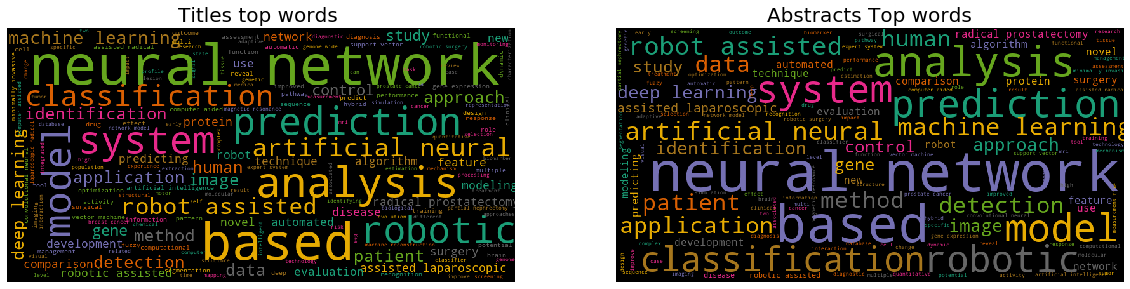

In [14]:
titles = ' '.join(X1)
abstracts = ' '.join(X1)

word_cloud_title = WordCloud(max_font_size = None, stopwords= stop_words,scale = 2,colormap = 'Dark2').generate(titles)
word_cloud_abstract = WordCloud(max_font_size = None, stopwords= stop_words,scale = 2,colormap = 'Dark2').generate(abstracts)

fig, ax = plt.subplots(1,2, figsize=(20, 5))
ax[0].imshow(word_cloud_title)
ax[0].set_title('Titles top words ',fontsize = 20)
ax[0].axis("off")

ax[1].imshow(word_cloud_abstract)
ax[1].set_title('Abstracts Top words',fontsize = 20)
ax[1].axis("off")

In [0]:
def group_list(lst):
    """ 
    Regroupez une liste de valeurs en n-tuples consécutifs (valeurs, nombre d'occurance). Les tuples incomplets sont jetés

    """
    res =  [(el, lst.count(el)) for el in lst] 
    return list(collections.OrderedDict(res).items())

In [0]:
grouped_list_cat = group_list(Y)
grouped_list_index = group_list(Y_indexed)

Un jeu de données *imbalanced* signifie qu’une ou plusieurs classes sont sous-représentées dans un problème de classification

In [17]:
sorted(grouped_list_cat, key=lambda x: x[1])

[('MATHEMATICS, APPLIED', 1),
 ('SOCIAL WORK', 1),
 ('HORTICULTURE', 1),
 ('STATISTICS & PROBABILITY', 1),
 ('MEDICAL ETHICS', 1),
 ('ENTOMOLOGY', 1),
 ('MARINE & FRESHWATER BIOLOGY', 2),
 ('ANDROLOGY', 2),
 ('TRANSPLANTATION', 2),
 ('EVOLUTIONARY BIOLOGY', 2),
 ('MATERIALS SCIENCE, BIOMATERIALS', 3),
 ('REPRODUCTIVE BIOLOGY', 4),
 ('SUBSTANCE ABUSE', 4),
 ('POLYMER SCIENCE', 4),
 ('PARASITOLOGY', 6),
 ('CHEMISTRY, PHYSICAL', 6),
 ('ECOLOGY', 6),
 ('INTEGRATIVE & COMPLEMENTARY MEDICINE', 7),
 ('MATERIALS SCIENCE, MULTIDISCIPLINARY', 7),
 ('ZOOLOGY', 8),
 ('RHEUMATOLOGY', 9),
 ('DEVELOPMENTAL BIOLOGY', 9),
 ('ROBOTICS', 10),
 ('EDUCATION, SCIENTIFIC DISCIPLINES', 10),
 ('PERIPHERAL VASCULAR DISEASE', 11),
 ('HEMATOLOGY', 11),
 ('HISTORY & PHILOSOPHY OF SCIENCE', 11),
 ('RESPIRATORY SYSTEM', 11),
 ('SPORT SCIENCES', 12),
 ('INFECTIOUS DISEASES', 12),
 ('AGRICULTURE, DAIRY & ANIMAL SCIENCE', 14),
 ('CRITICAL CARE MEDICINE', 14),
 ('EMERGENCY MEDICINE', 14),
 ('ANATOMY & MORPHOLOGY', 15),


In [18]:
"""
Nous remarquons que les catégories sont déséquilibrées ce qui explique le fait que le score à l'étape d'apprentissage

est beaucoup plus élevé que celui de test (>90% train vs ~35-43% test). 

Nous allons donc chercher les catégories contenant <200 articles

"""

elements_with_low_frequency_cat = [(x,y) for (x,y) in grouped_list_cat if y < 200]
elements_with_low_frequency_index = [(x,y) for (x,y) in grouped_list_index if y < 200]

print(sorted(elements_with_low_frequency_cat, key=lambda x: x[1]))
print(f'Le nombre de catégories inférieures à 200 articles : {len(elements_with_low_frequency_cat)} catégories')

[('MATHEMATICS, APPLIED', 1), ('SOCIAL WORK', 1), ('HORTICULTURE', 1), ('STATISTICS & PROBABILITY', 1), ('MEDICAL ETHICS', 1), ('ENTOMOLOGY', 1), ('MARINE & FRESHWATER BIOLOGY', 2), ('ANDROLOGY', 2), ('TRANSPLANTATION', 2), ('EVOLUTIONARY BIOLOGY', 2), ('MATERIALS SCIENCE, BIOMATERIALS', 3), ('REPRODUCTIVE BIOLOGY', 4), ('SUBSTANCE ABUSE', 4), ('POLYMER SCIENCE', 4), ('PARASITOLOGY', 6), ('CHEMISTRY, PHYSICAL', 6), ('ECOLOGY', 6), ('INTEGRATIVE & COMPLEMENTARY MEDICINE', 7), ('MATERIALS SCIENCE, MULTIDISCIPLINARY', 7), ('ZOOLOGY', 8), ('RHEUMATOLOGY', 9), ('DEVELOPMENTAL BIOLOGY', 9), ('ROBOTICS', 10), ('EDUCATION, SCIENTIFIC DISCIPLINES', 10), ('PERIPHERAL VASCULAR DISEASE', 11), ('HEMATOLOGY', 11), ('HISTORY & PHILOSOPHY OF SCIENCE', 11), ('RESPIRATORY SYSTEM', 11), ('SPORT SCIENCES', 12), ('INFECTIOUS DISEASES', 12), ('AGRICULTURE, DAIRY & ANIMAL SCIENCE', 14), ('CRITICAL CARE MEDICINE', 14), ('EMERGENCY MEDICINE', 14), ('ANATOMY & MORPHOLOGY', 15), ('MICROSCOPY', 15), ('PHYSIOLOGY'

Pour bien explorer les données, nous allons aussi chercher les catégories < 20 articles

In [19]:
elements_with_low_frequency_10 = [(x,y) for (x,y) in grouped_list_cat if y < 20]
print(f'Le nombre de catégories inférieures à 20 articles : {len(elements_with_low_frequency_10)} catégories')
# 41 catégories soit ~43% 

Le nombre de catégories inférieure à 20 articles : 41 catégories


### Répartir le dataset en base d’apprentissage et de test

In [0]:
X_train, X_test, Y_train, Y_test =  train_test_split(pd.DataFrame([X1, X2]).T, Y_indexed, test_size = 0.2, random_state = 42)
X_train_title, X_train_abstract = X_train[0], X_train[1]
X_test_title, X_test_abstract = X_test[0], X_test[1]

  On va donc chercher si toutes les catégories existent dans l'échantillon d'apprentissage

In [21]:
print(f'Y_train ne contient que {len(group_list(Y_train))}/97 catégories')
print(f'Y_test ne contient que {len(group_list(Y_test))}/97 catégories')

Y_train ne contient que 95/97 catégories
Y_test ne contient que 87/97 catégories


Cela veut dire que le modèle va devoir prédire des catégories qu'il n'a pas vu pendant son apprentissage, et vu qu'on devrait faire une validation avec 20% de X_train, cela va encore baisser le nombre de catégories durant la phase de training.

### La création d'un dataframe avant la data augmentation

In [0]:
input_dataframe = pd.DataFrame(dataset_pubmed)[['title', 'abstract']]
input_dataframe["categories_computed"] = pd.DataFrame(dataset_pubmed).apply(lambda x: x["categories"][0],axis=1)
input_dataframe["cat_to_index"] = input_dataframe.apply(lambda x: dict_categories_to_indexes[x["categories_computed"]], axis=1)

In [23]:
input_dataframe.tail(10)

,title,abstract,categories_computed,cat_to_index
9990,The order of complexity of visuomotor learning.,Learning algorithms come in three orders of co...,NEUROSCIENCES,4
9991,Robot-assisted intrafascial simple prostatecto...,We describe our initial experience with intraf...,UROLOGY & NEPHROLOGY,12
9992,Transcriptomic comparison of the self-pollinat...,Self-incompatibility (SI) is a widespread and ...,PLANT SCIENCES,28
9993,"Consciousness: here, there and everywhere?",The science of consciousness has made great st...,BIOLOGY,24
9994,"A comparison of robotic, laparoscopic, and han...",Robotic surgery offers all the advantages of l...,SURGERY,10
9995,Modeling the antileishmanial activity screenin...,QSAR analysis for modeling the antileishmanial...,"CHEMISTRY, MEDICINAL",69
9996,Robot-Assisted Laparoscopic Adenomyomectomy fo...,An adenomyomectomy is a conservative-surgical ...,"MEDICINE, GENERAL & INTERNAL",8
9997,Brain chaos and computation.,A model cortex comprising two interconnected s...,"COMPUTER SCIENCE, ARTIFICIAL INTELLIGENCE",6
9998,Robotically assisted ablation produces more ra...,Robotic remote catheter ablation potentially p...,CARDIAC & CARDIOVASCULAR SYSTEMS,16
9999,Transcriptomic Analysis of Calonectria pseudor...,Eucalyptus leaf blight caused by Calonectria s...,MULTIDISCIPLINARY SCIENCES,5


### Les fonctions nécessaires pour la data augmentation

In [0]:
def sentence_from_text(text, nb_of_words_to_retrieve):
    """
      Pour créer des titres et des abstracts à partir des articles tirés aléatoirement à chaque fois
      Le principe est de supprimer nb_of_words_to_retrieve, swap un nombre aléatoire de mots et recherche
      des synonymes dans wordnet

    """
    words = word_augmentation(text).split()
    assert nb_of_words_to_retrieve <= len(words)
    for i in range(nb_of_words_to_retrieve):
      choice = random.randint(0, len(words) - 1)
      del words[choice]
    return ' '.join(words)

def word_augmentation(text):
    aug1 = naw.RandomWordAug(action="swap")
    augmented_text1 = aug1.augment(text)
    aug3 = naw.SynonymAug(aug_src='wordnet')
    augmented_text3 = aug3.augment(augmented_text1)
    return augmented_text3

def dataset_reinforcement(input_dataframe, elements_with_low_frequency):
    """

    Pour renforcer les catégories dans un dataframe à partir d'une liste des élements
  
    """    
    elements_with_low_frequency_dict = {x:y for (x,y) in elements_with_low_frequency}
    exclude = []
    for index, row in input_dataframe.iterrows():
        if row[3] in elements_with_low_frequency_dict.keys() and row[3] not in exclude:
            for i in range(elements_with_low_frequency_dict[row[3]], 200, 1):
                random_dict = input_dataframe[input_dataframe['cat_to_index'] == row[3]].sample(n = 10, replace=True).to_dict('records')[0]
                dict_temp = {'title':sentence_from_text(random_dict['title'], 0),
                                    'abstract':sentence_from_text(random_dict['abstract'], 1), 
                                    'categories_computed':row[2], 
                                    'cat_to_index':row[3]}
                input_dataframe = input_dataframe.append(dict_temp, ignore_index=True)
            exclude.append(row[3])
    return input_dataframe.sample(frac = 1).reset_index(drop=True)

### La data augmentation

In [27]:
# la création de nouveau dataframe 
import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
dataframe_after_reinforcement = dataset_reinforcement(input_dataframe, elements_with_low_frequency_index)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [30]:
dataframe_after_reinforcement.head()

,title,abstract,categories_computed,cat_to_index
0,A screening smear-negative organisation for t....,Tests molecular show sensitivity for low smear...,INFECTIOUS DISEASES,78
1,Generating coherent patterns of activity from ...,Neural circuits display complex activity patte...,NEUROSCIENCES,4
2,Artificial intelligence exploration of unstabl...,Protocell models are used to investigate how c...,MULTIDISCIPLINARY SCIENCES,5
3,Connection chemical between chemical shape kno...,"During the past four decades, there has been a...",ANDROLOGY,86
4,Application of artificial neural network to co...,We have developed a computerized system that c...,"RADIOLOGY, NUCLEAR MEDICINE & MEDICAL IMAGING",2


In [31]:
print(f'Le nouveau dataset contient {len(dataframe_after_reinforcement)} articles') # plus de 23000 articles

Le nouveau dataset contient 23648 articles


In [0]:
# sauvegarder le csv
dataframe_after_reinforcement.to_csv('data_after_augmentation.csv', index=False)
data_pubmed = dataframe_after_reinforcement.to_dict('records') # remplacer la variable data_pubmed

### La création des variables X1, X2, Y_indexed après la data augmentation

In [0]:
X1 = []
X2 = []
Y_indexed = []
for row in data_pubmed:
    try:
        X1.append(row["title"][:-1].lower())
        X2.append(row['abstract'][:-1].lower())
        Y_indexed.append(row['cat_to_index'])
    except:
        pass

### Répartir le dataset en base d’apprentissage et de test

In [0]:
# utilisation de la fonction train_test_split pour séparer le dataset
X_train, X_test, Y_train, Y_test =  train_test_split(pd.DataFrame([X1, X2]).T, Y_indexed, test_size = 0.2, random_state = 42)
X_train_title, X_train_abstract = X_train[0], X_train[1]
X_test_title, X_test_abstract = X_test[0], X_test[1]

  Il faut vérifier si X_train contient toutes les catégories

In [36]:
print(f'Y_train ne contient que {len(group_list(Y_train))}/97 catégories')
print(f'Y_test ne contient que {len(group_list(Y_test))}/97 catégories')

Y_train ne contient que 97/97 catégories
Y_test ne contient que 97/97 catégories


### La création des vocabulaires : un pour les titres et l'autre pour les abstracts

In [0]:

"""
La création de vocabulaire à partir d'une liste de données
Suppression : stop words, ponctuation, un seul caractère, numéros, etc...
return le vocabulaire trié par ordre décroissant selon le nombre d'occurences de chaque mot
"""

# Pour stemmer
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()

# stopWords des articles PUBMED
with open("/content/drive/My Drive/keras/stopwords.txt", 'r') as file:
    stop_words = (file.read()).split()

def create_vocabulary(df, StopWords):
    deleted_words = {}
    vocabulary = {}
    for sample in df:
        for word in re.compile('\w+').findall(sample):
            #word = porter.stem(word)
            if word not in StopWords and word not in vocabulary and word.isalpha() and len(word) > 1:
                vocabulary[word] = 1
            elif word in vocabulary:
                vocabulary[word] += 1
            else:
                if word not in deleted_words:
                    deleted_words[word] = 1
                else:
                    deleted_words[word] += 1
    vocabulary = {k: v for k, v in sorted(vocabulary.items(), key=lambda item: item[1], reverse = True)}
    deleted_words = sorted(deleted_words.items(), key=lambda item: item[1], reverse = True)
    return vocabulary, deleted_words

def preprocess_X(X, vocabulary):
    titles_to_indexes = []
    for title in X:
        title_to_index = []
        for word in title.split():
            #word = porter.stem(word)
            if word in vocabulary:
                title_to_index.append(vocabulary[word])
            else:
                title_to_index.append(vocabulary['<UNK>'])
        titles_to_indexes.append(title_to_index)
    return titles_to_indexes

In [38]:
vocabulary_title, deleted_words_title = create_vocabulary(X_train_title, stop_words)
vocabulary_abstract, deleted_words_abstract = create_vocabulary(X_train_abstract, stop_words)
print(f'La taille de vocabulaire pour les titres : {len(vocabulary_title)}')
print(f'et nous avons éliminé : {len(deleted_words_title)} mots différents')
print(f'La taille de vocabulaire pour les abstracts : {len(vocabulary_abstract)}')
print(f'et nous avons éliminé : {len(deleted_words_abstract)} mots différents')

La taille de vocabulaire pour les titre : 16314
et nous avons éliminé : 567 mots différents
La taille de vocabulaire pour les abstracts : 40674
et nous avons éliminé : 4584 mots différents


In [0]:
# prendre les elements les plus fréquents (~70%)
vocabulary_title = dict(itertools.islice(vocabulary_title.items(), int(len(vocabulary_title) * 0.7)))
vocabulary_abstract = dict(itertools.islice(vocabulary_abstract.items(), int(len(vocabulary_abstract) * 0.7)))

# indexation de notre vocabulaire
vocabulary_final_title = cat_to_index(vocabulary_title)
vocabulary_final_abstract = cat_to_index(vocabulary_abstract)

In [40]:
len(vocabulary_final_title), len(vocabulary_final_abstract)

(11420, 28472)

### Création des séquences et padding

In [0]:
title_max_len_cars = len((max(X1, key=len)))
title_max_len_words = len(max(X1, key=len).split())
abstract_max_len_cars = len((max(X2, key=len)))
abstract_max_len_words = len(max(X2, key=len).split())

Il faut chercher max length pour les titres et les variables avant de faire le padding

In [42]:
print(f'Le nombre max des mots dans un titre est : {title_max_len_words}')
print(f'Le nombre max des mots dans un abstract est : {abstract_max_len_words}')

Le nombre max des mots dans un titre est : 39
Le nombre max des mots dans un abstract est : 1495


### 1. Titres

In [0]:
X_train_title_preprocess = preprocess_X(X_train_title, vocabulary_final_title)
X_test_title_preprocess = preprocess_X(X_test_title, vocabulary_final_title)


# Padding des sequences
X_train_title_seq = sequence.pad_sequences(X_train_title_preprocess, maxlen = title_max_len_words, padding = 'post', truncating='post')
X_test_title_seq = sequence.pad_sequences(X_test_title_preprocess, maxlen = title_max_len_words, padding = 'post', truncating='post')


### 2.Abstracts

In [0]:
X_train_abstract_preprocess = preprocess_X(X_train_abstract, vocabulary_final_abstract)
X_test_abstract_preprocess = preprocess_X(X_test_abstract, vocabulary_final_abstract)


# Padding des sequences
X_train_abstract_seq = sequence.pad_sequences(X_train_abstract_preprocess, maxlen = abstract_max_len_words, padding = 'post', truncating='post')
X_test_abstract_seq = sequence.pad_sequences(X_test_abstract_preprocess, maxlen = abstract_max_len_words, padding = 'post', truncating='post')


### Utilisation des embeddings pré-entraînés

In [0]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1 
    embedding_matrix = np.random.uniform(-0.25, 0.25, (vocab_size, embedding_dim))
    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

In [0]:
embedding_dim = 300
embedding_matrix_title = create_embedding_matrix('/content/drive/My Drive/keras/glove.6B.300d.txt', vocabulary_final_title, embedding_dim)
embedding_matrix_abstract = create_embedding_matrix('/content/drive/My Drive/keras/glove.6B.300d.txt', vocabulary_final_abstract, embedding_dim)

### Entrainement des modèles

### 1. Titres seuls

### 1.1 CNN

In [0]:
VERBOSE = 1
BATCH_SIZE = 128
INPUT_LENGTH_TITLE = X_train_title_seq.shape[1]
INPUT_LENGTH_ABSTRACT = X_train_abstract_seq.shape[1]
OUTPUT = 98
VALIDATION_SPLIT = 0.2
EMBED_DIM = 256
LSTM_OUT = 128
NB_EPOCHS = 5
INPUT_DIM_TITLE = len(vocabulary_final_title) + 1
INPUT_DIM_ABSTRACT = len(vocabulary_final_abstract) + 1
FILTERS = 200
KERNEL_SIZE = 3

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 40, 256)           2905344   
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 38, 200)           153800    
_________________________________________________________________
batch_normalization_16 (Batc (None, 38, 200)           800       
_________________________________________________________________
activation_31 (Activation)   (None, 38, 200)           0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 38, 200)           0         
_________________________________________________________________
global_max_pooling1d_16 (Glo (None, 200)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 98)              

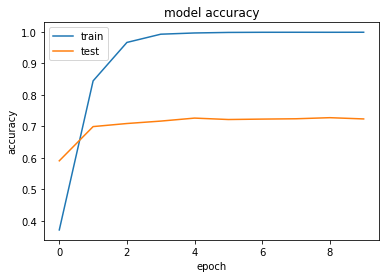

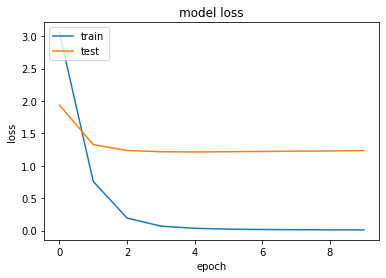

In [0]:
# Créer le modèle
model_CNN_title = Sequential()
model_CNN_title.add(Embedding(INPUT_DIM_TITLE, EMBED_DIM, input_length = INPUT_LENGTH_TITLE))
model_CNN_title.add(Conv1D(filters = FILTERS, kernel_size = KERNEL_SIZE, padding='valid',
                 strides=1))
model_CNN_title.add(BatchNormalization(axis=-1))
model_CNN_title.add(Activation('relu'))
model_CNN_title.add(Dropout(0.1))
model_CNN_title.add(GlobalMaxPooling1D())
model_CNN_title.add(Dense(OUTPUT))
model_CNN_title.add(Activation('softmax'))
print(model_CNN_title.summary())

# Compiler le modèle
model_CNN_title.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model_CNN_title.fit(X_train_title_seq, Y_train,  epochs = 10,
                                verbose = 1, validation_split = VALIDATION_SPLIT, batch_size = BATCH_SIZE)
score = model_CNN_title.evaluate(X_test_title_seq, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

# Liste de données dans l'historique
print(history.history.keys())

# Plot pour comparer accuracy et validate accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

# Plot pour comparer loss et validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

### 1.2 LSTM Bidirectional

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 39, 300)           3426300   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 39, 300)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 256)               439296    
_________________________________________________________________
dropout_17 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 98)                25186     
_________________________________________________________________
activation_29 (Activation)   (None, 98)                0         
Total params: 3,890,782
Trainable params: 3,890,782
Non-trainable params: 0
___________________________________________

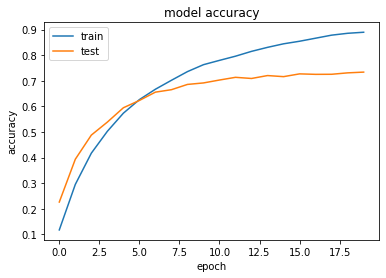

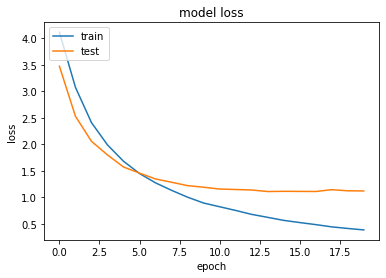

In [62]:
# Définir le modèle
model_LSTM_title = Sequential()
model_LSTM_title.add(Embedding(embedding_matrix_title.shape[0], embedding_matrix_title.shape[1], input_length = INPUT_LENGTH_TITLE,
                           weights=[embedding_matrix_title], 
                           trainable=True))
model_LSTM_title.add(SpatialDropout1D(0.5))
model_LSTM_title.add(Bidirectional(LSTM(LSTM_OUT)))
model_LSTM_title.add(Dropout(0.2))
model_LSTM_title.add(Dense(OUTPUT))
model_LSTM_title.add(Activation('softmax'))
print(model_LSTM_title.summary())

# Compiler le modèle
model_LSTM_title.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model_LSTM_title.fit(X_train_title_seq, Y_train,  epochs = 20,  verbose = VERBOSE, 
                                 validation_split=VALIDATION_SPLIT, batch_size = BATCH_SIZE)
score = model_LSTM_title.evaluate(X_test_title_seq, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

# Liste de données dans l'historique
print(history.history.keys())

# Plot pour comparer accuracy et validate accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

# Plot pour comparer loss et validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

### 2 Abstracts

### 2.1 CNN

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 1495, 256)         7289088   
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 1493, 200)         153800    
_________________________________________________________________
batch_normalization_8 (Batch (None, 1493, 200)         800       
_________________________________________________________________
activation_17 (Activation)   (None, 1493, 200)         0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 1493, 200)         0         
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 200)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 98)              

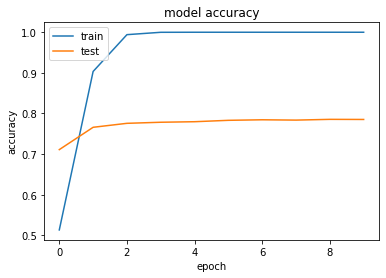

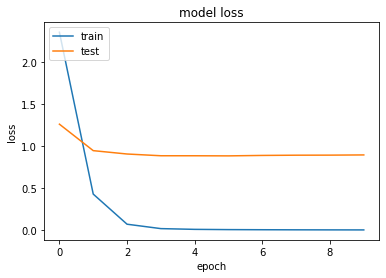

In [57]:
# Définir le modèle
model_CNN_abstract = Sequential()
model_CNN_abstract.add(Embedding(INPUT_DIM_ABSTRACT, EMBED_DIM, input_length = INPUT_LENGTH_ABSTRACT))
model_CNN_abstract.add(Conv1D(filters = FILTERS, kernel_size = KERNEL_SIZE, ))
model_CNN_abstract.add(BatchNormalization(axis=-1))
model_CNN_abstract.add(Activation('relu'))
model_CNN_abstract.add(Dropout(0.1))
model_CNN_abstract.add(GlobalMaxPooling1D())
model_CNN_abstract.add(Dense(OUTPUT))
model_CNN_abstract.add(Activation('softmax'))
print(model_CNN_abstract.summary())

# Compiler le modèle
model_CNN_abstract.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model_CNN_abstract.fit(X_train_abstract_seq, Y_train,  epochs = 10,  verbose = VERBOSE, 
                                 validation_split = VALIDATION_SPLIT, batch_size = BATCH_SIZE)
score = model_CNN_abstract.evaluate(X_test_abstract_seq, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

# Liste de données dans l'historique
print(history.history.keys())

# Plot pour comparer accuracy et validate accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

# Plot pour comparer loss et validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

### 2.2 LSTM Bidirectional

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_26 (Embedding)     (None, 1495, 300)         8541300   
_________________________________________________________________
spatial_dropout1d_7 (Spatial (None, 1495, 300)         0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 256)               439296    
_________________________________________________________________
dropout_26 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 98)                25186     
_________________________________________________________________
activation_43 (Activation)   (None, 98)                0         
Total params: 9,005,782
Trainable params: 9,005,782
Non-trainable params: 0
___________________________________________

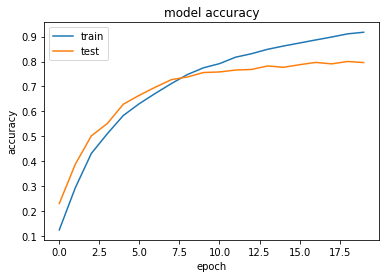

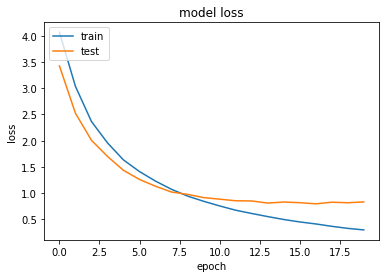

In [67]:
# Définir le modèle
model_LSTM_abstract = Sequential()
model_LSTM_abstract.add(Embedding(embedding_matrix_abstract.shape[0], embedding_matrix_abstract.shape[1], 
                       input_length = INPUT_LENGTH_ABSTRACT, 
                       weights=[embedding_matrix_abstract], 
                       trainable=True))
model_LSTM_abstract.add(SpatialDropout1D(0.5))
model_LSTM_abstract.add(Bidirectional(LSTM(LSTM_OUT)))
model_LSTM_abstract.add(Dropout(0.2))
model_LSTM_abstract.add(Dense(OUTPUT))
model_LSTM_abstract.add(Activation('softmax'))
print(model_LSTM_abstract.summary())

# Compiler le modèle
model_LSTM_abstract.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model_LSTM_abstract.fit(X_train_abstract_seq, Y_train,  epochs = 20,  verbose = VERBOSE, 
                                  validation_split=VALIDATION_SPLIT, batch_size = BATCH_SIZE)
score = model_LSTM_abstract.evaluate(X_test_abstract_seq, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

# Liste de données dans l'historique
print(history.history.keys())

# Plot pour comparer accuracy et validate accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

# Plot pour comparer loss et validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

### 3 Titres et Abstracts

3.1 CNN à 2 inputs

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_27_input (InputLayer) (None, 39)           0                                            
__________________________________________________________________________________________________
embedding_28_input (InputLayer) (None, 1495)         0                                            
__________________________________________________________________________________________________
embedding_27 (Embedding)        (None, 39, 256)      2923776     embedding_27_input[0][0]         
__________________________________________________________________________________________________
embedding_28 (Embedding)        (None, 1495, 256)    7289088     embedding_28_input[0][0]         
____________________________________________________________________________________________

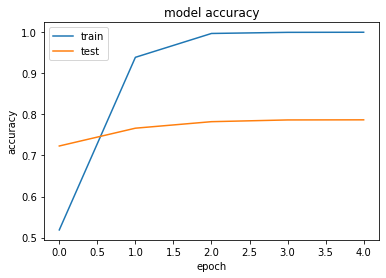

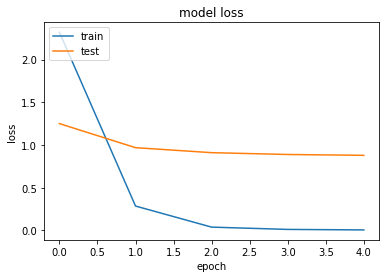

In [69]:
# Entrée 01
model_title = Sequential()
model_title.add(Embedding(INPUT_DIM_TITLE, EMBED_DIM, input_length = INPUT_LENGTH_TITLE))
model_title.add(Conv1D(filters = FILTERS, kernel_size = KERNEL_SIZE))
model_title.add(BatchNormalization(axis=-1))
model_title.add(Activation('relu'))
model_title.add(Dropout(0.1))
model_title.add(GlobalMaxPooling1D())

# Entrée 02
model_abstract = Sequential()
model_abstract.add(Embedding(INPUT_DIM_ABSTRACT, EMBED_DIM, input_length = INPUT_LENGTH_ABSTRACT))
model_abstract.add(Conv1D(filters = FILTERS, kernel_size = KERNEL_SIZE))
model_abstract.add(BatchNormalization(axis=-1))
model_abstract.add(Activation('relu'))
model_abstract.add(Dropout(0.3))
model_abstract.add(GlobalMaxPooling1D())

# Concaténation
concat_layers = concatenate([model_title.output, model_abstract.output], axis=-1)
layer = Dense(OUTPUT)(concat_layers)
outlayer = Activation('softmax')(layer)
model = Model([model_title.input, model_abstract.input], [outlayer])

# Compilation
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())
history = model.fit([np.array(X_train_title_seq), np.array(X_train_abstract_seq)], np.array(Y_train), batch_size = BATCH_SIZE, 
                    epochs = 5, verbose = VERBOSE, validation_split = VALIDATION_SPLIT)
score = model.evaluate([np.array(X_test_title_seq), np.array(X_test_abstract_seq)], np.array(Y_test), verbose = VERBOSE)
print("Test loss:", score[0])
print('Test accuracy:', score[1])

# Lists de données dans l'historique
print(history.history.keys())

# Plot pour comparer accuracy et validate accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

# Plot pour comparer loss et validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

3.2 LSTM Bidirectional à 02 inputs










Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_1_input (InputLayer)  (None, 47)           0                                            
__________________________________________________________________________________________________
embedding_2_input (InputLayer)  (None, 1495)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 47, 300)      3414000     embedding_1_input[0][0]          
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1495, 300)    8526900     

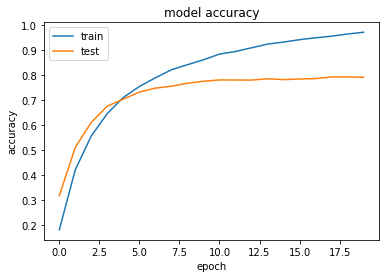

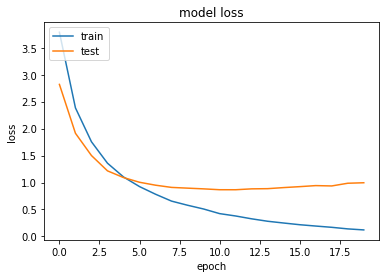

In [0]:
# Entrée 01
model_title = Sequential()
model_title.add(Embedding(embedding_matrix_title.shape[0], embedding_matrix_title.shape[1], input_length = INPUT_LENGTH_TITLE,
                          weights=[embedding_matrix_title], 
                          trainable=True,
                          ))
model_title.add(SpatialDropout1D(0.5))
model_title.add(Bidirectional(LSTM(LSTM_OUT)))
model_title.add(Dropout(0.2))

# Entrée 02
model_abstract = Sequential()
model_abstract.add(Embedding(embedding_matrix_abstract.shape[0], embedding_matrix_abstract.shape[1], input_length = INPUT_LENGTH_ABSTRACT,
                             weights=[embedding_matrix_abstract], 
                             trainable=True,
                             ))
model_abstract.add(SpatialDropout1D(0.5))
model_abstract.add(Bidirectional(LSTM(LSTM_OUT)))
model_abstract.add(Dropout(0.2))

# Concaténation
concat_layers = concatenate([model_title.output, model_abstract.output], axis=-1)
layer = Dense(OUTPUT)(concat_layers)
outlayer = Activation('softmax')(layer)
model = Model([model_title.input, model_abstract.input], [outlayer])

# Compilation
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())
history = model.fit([np.array(X_train_title_seq), np.array(X_train_abstract_seq)], np.array(Y_train), batch_size = BATCH_SIZE, epochs = 20,
verbose = VERBOSE, validation_split = VALIDATION_SPLIT)
score = model.evaluate([np.array(X_test_title_seq), np.array(X_test_abstract_seq)], np.array(Y_test), verbose = VERBOSE)
print("Test loss:", score[0])
print('Test accuracy:', score[1])

# Liste de données dans l'historique
print(history.history.keys())

# Plot pour comparer accuracy et validate accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

# Plot pour comparer loss et validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()